In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
import smplotlib
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14
    
import numpy as np
import pandas as pd
from astropy.table import Table
from astropy.io import fits
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from nuwa.wlkernelgp import wl_GaussianProcess
import pickle
from skopt import BayesSearchCV
from skopt.space import Real, Integer
# from nuwa.wlkernel import make_graph, calculate_grakel_graph, GaussianProcess
np.set_printoptions(suppress=True)


In [2]:
n_train = 200
n_star  = 5000
data_dir = "/nfsdata/users/jdli_ny/wlkernel/mock/"
# data = np.load(data_dir+f'binary_train_flatZ_abg_{n_train}tr_{n_star}cmd.npz')
data = np.load(data_dir + f'binary_train_flatZ_abg_baseline.npz')
# dname = data_dir + f'binary_train_moh_m0p5_0_abg_{n_train}tr_{n_star}cmd.npz'
# data = np.load(dname)


# Split X and Y into training and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(
    data['X'], data['Y'], test_size=0.1, random_state=42
)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(450, 2000, 2) (50, 2000, 2) (450, 3) (50, 3)


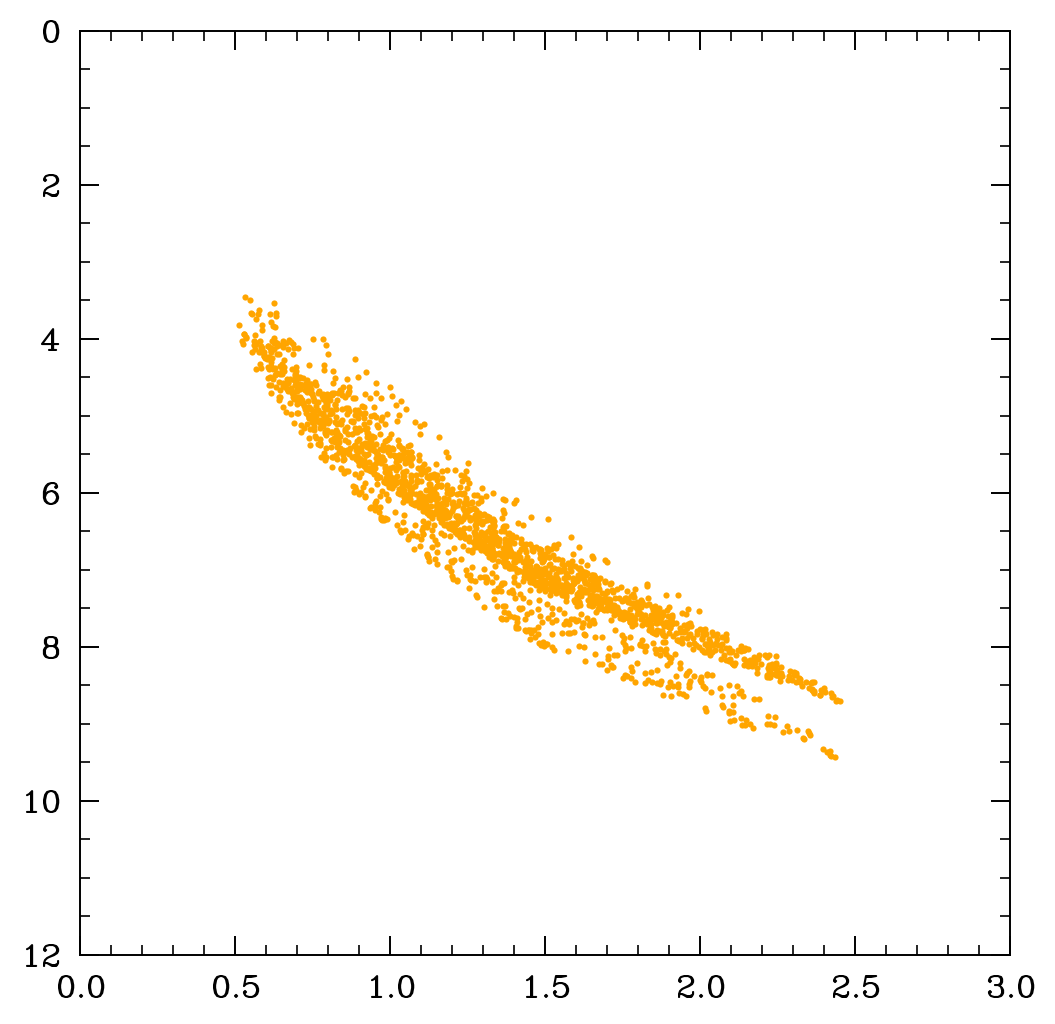

In [3]:
plt.scatter(data['X'][0][:,0], data['X'][0][:,1],  s=5, c='orange', linewidths=0)


plt.ylim(12, 0);
plt.xlim(0, 3);

In [4]:
test_dir = "/nfsdata/users/jdli_ny/wlkernel/test/"
y_pred = np.load(test_dir+'ypred_baseline.npy')

print(y_pred)

[[ 3.15476655  0.35480411  1.56502097]
 [ 3.40103678  0.71001119  0.70448847]
 [ 1.83070509  0.14897247  0.14695189]
 [ 2.46787946  0.24064851  2.10316746]
 [ 3.20088255  0.18792013  1.53383534]
 [ 2.54057175  0.72505247  2.29380407]
 [ 1.59312564  0.55905107  2.10092964]
 [ 2.011482    0.52494817  2.49162703]
 [ 1.68463076  0.81089183  0.97364405]
 [ 3.45900695  0.68309886  1.84966734]
 [ 2.68631175  0.82202951  1.43311153]
 [ 2.14552798  0.12496145  0.85310253]
 [ 2.68177699  0.68214227  2.28473318]
 [ 2.20278178  0.66740231  2.69672033]
 [ 1.96481236  0.34176081  1.26341691]
 [ 2.88801231  0.17186479  1.96729477]
 [ 2.39692965  0.13404843  1.65071971]
 [ 2.66059392  1.03379652  0.23338692]
 [ 2.93707138  0.63016879  1.52197564]
 [ 3.0448761   0.30755959  2.06595763]
 [ 2.22361651  0.82205124  1.53770491]
 [ 2.7036504   0.76336699  1.13362052]
 [ 3.44980084  0.77675941  2.0647867 ]
 [ 2.09324308  0.1800612   0.55947151]
 [ 2.87743969  0.22462157  1.75311381]
 [ 2.87152563  0.7191038 

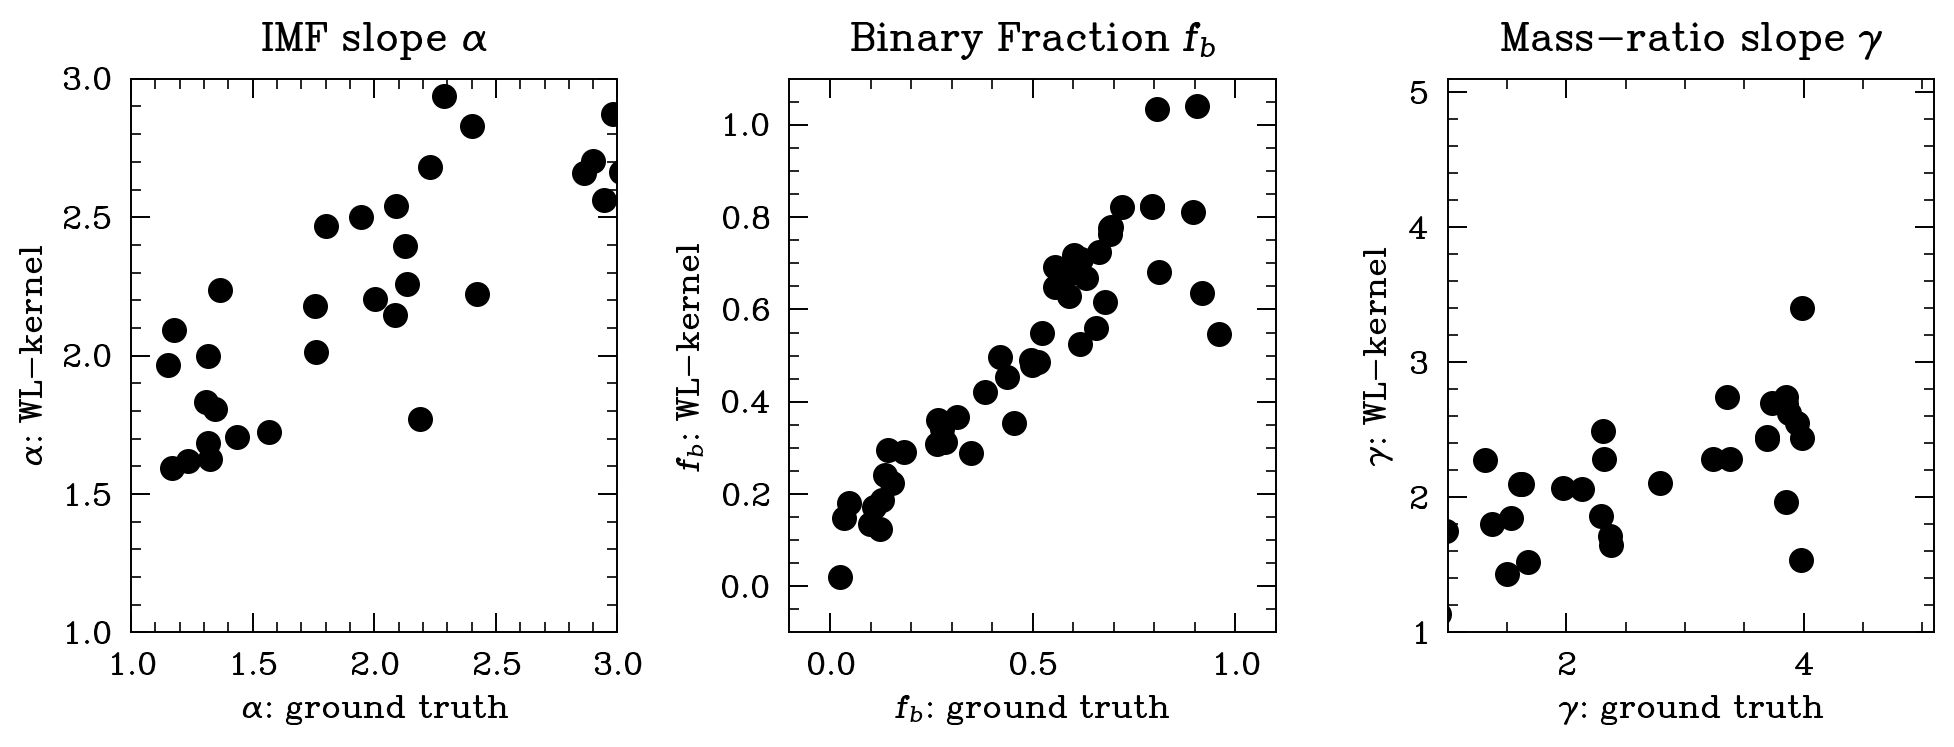

In [5]:
# Create one-to-one comparison plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 4))

ax1.scatter(Y_test[:,0], y_pred[:,0], )
ax2.scatter(Y_test[:,1], y_pred[:,1], )
ax3.scatter(Y_test[:,2], y_pred[:,2], )

ax1.set_xlim(1., 3.);
ax1.set_ylim(1., 3.);
ax1.set_xlabel(r"$\alpha$: ground truth");
ax1.set_ylabel(r"$\alpha$: WL-kernel");


ax2.set_xlim(-0.1, 1.1);
ax2.set_ylim(-0.1, 1.1);
ax2.set_xlabel(r"$f_b$: ground truth");
ax2.set_ylabel(r"$f_b$: WL-kernel");


ax3.set_xlim(1, 5.1);
ax3.set_ylim(1, 5.1);
ax3.set_xlabel(r"$\gamma$: ground truth");
ax3.set_ylabel(r"$\gamma$: WL-kernel");

ax1.set_title(r'IMF slope $\alpha$')
ax2.set_title(r'Binary Fraction $f_b$')
ax3.set_title(r'Mass-ratio slope $\gamma$')

plt.tight_layout()

In [3]:
def calculate_mse(y_true, y_pred):
    """
    Calculate the Mean Squared Error (MSE) between true values and predicted values.

    Parameters:
    - y_true: numpy array or list, true values
    - y_pred: numpy array or list, predicted values

    Returns:
    - mse: float, Mean Squared Error
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mse = np.mean((y_true - y_pred) ** 2)
    return mse


def objective_function(hyperparameters):
    radius = hyperparameters['radius']
    # subsample_factor = hyperparameters['subsample_factor']
    n_iter = hyperparameters['n_iter']

    # Create an instance of the wl_GaussianProcess class
    wl_gp = wl_GaussianProcess(
        radius=radius, n_iter=n_iter
        )

    # Train the model
    wl_gp.train(X_train)

    # Make predictions on the test set
    y_pred = wl_gp.predict(X_test)

    # Calculate your desired performance metric (e.g., mean squared error)
    mse = calculate_mse(Y_test, y_pred)

    # Return the negative mean squared error (skopt minimizes the objective function)
    return -mse



opt = BayesSearchCV(
    wl_GaussianProcess(),
    {
        'radius': Real(1e-3, 1e+3, prior='log-uniform'),
        'n_iter': Integer(1, 10),
    },
    n_iter=32, random_state=0,
    n_jobs=48, 
    cv=5, verbose=5, 
    scoring=objective_function,
)

# executes bayesian optimization
_ = opt.fit(X_train, Y_train)




Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3; 1/1] START n_iter=6, radius=11.388776056171363.........................
[CV 1/3; 1/1] START n_iter=6, radius=11.388776056171363.........................
[CV 2/3; 1/1] START n_iter=6, radius=11.388776056171363.........................


100%|██████████| 300/300 [01:43<00:00,  2.91it/s]


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}